In [1]:
import Pkg; Pkg.activate("../scripts")
Pkg.instantiate()
using Revise
using PlutoUI
using TMI
using Test
using PythonCall
using CondaPkg
using PythonPlot
const sns = pyimport("seaborn")

const cartopy = pyimport("cartopy")
const matplotlib = pyimport("matplotlib")

ccrs = cartopy.crs

import Pkg;
using Interpolations
using Statistics
using LinearAlgebra
plotsdir(x) = "/Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/TMI.jl/plots/" * x
include("../src/sample_observations.jl")

using NaNStatistics

const mpl = pyimport("matplotlib")
mpl.rcParams["figure.dpi"] = 200


  Activating project at `~/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/TMI.jl/scripts`


200

In [2]:
custom_style = Dict("text.color" => "black")

Dict{String, String} with 1 entry:
  "text.color" => "black"

In [3]:
sns.set_theme(context="notebook", style="ticks", palette = "colorblind", rc=custom_style)

Python: None

In [4]:
TMIversion = "modern_90x45x33_G14_v2";
A, Alu, γ, TMIfile, L, B = config_from_nc(TMIversion); println(sum(cellvolume(γ)))
volume = volumefilled(TMIversion,Alu,γ); println(maximum(volume))
volume = (10 .^ volume.tracer) .* cellarea(γ).tracer
volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,γ.wet[:,:,1],:V,"volume filled by surface gridcell","unknown")
volume_mod = 1 * volume 
TMIfile = TMI.pkgdatadir("TMI_"*TMIversion*".nc")
θ̄_mod = readfield(TMIfile, "θ", γ); #true mean
θ̄_mod_MOT = mean(θ̄_mod); #true mean
θ̄_mod_SST = getsurfaceboundary(θ̄_mod);

A
  0.305515 seconds (399.10 k allocations: 60.993 MiB, 5.77% gc time)
Alu
  0.880999 seconds (402.67 k allocations: 502.540 MiB, 4.36% gc time)
L=
  0.263279 seconds (475.82 k allocations: 31.652 MiB)
B=
  0.089874 seconds (32.42 k allocations: 2.129 MiB)
1.4442375457929354e18
6.611162189504795


In [5]:
TMIversion = "LGM_90x45x33_G14";
A, Alu, γ, TMIfile, L, B = config_from_nc(TMIversion); println(sum(cellvolume(γ))) 
volume = volumefilled(TMIversion,Alu,γ)
volume = (10 .^ volume.tracer) .* cellarea(γ).tracer
volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,γ.wet[:,:,1],:V,"volume filled by surface gridcell","unknown")
volume_LGM = 1. * volume 
TMIfile = TMI.pkgdatadir("TMI_"*TMIversion*".nc")
θ̄_LGM = readfield(TMIfile, "θ", γ); #true mean
θ̄_LGM_MOT = mean(θ̄_LGM); #true mean
θ̄_LGM_SST = getsurfaceboundary(θ̄_LGM);

A
  0.052529 seconds (3.45 k allocations: 34.589 MiB, 34.48% gc time)
Alu
  0.812739 seconds (81 allocations: 476.181 MiB, 2.45% gc time)
L=
  0.003276 seconds (373 allocations: 38.508 KiB)
B=
  0.002081 seconds (374 allocations: 38.531 KiB)
1.4442375457929354e18


In [6]:
ΔSST_lat =  1 * (θ̄_mod_SST.tracer .- θ̄_LGM_SST.tracer); ΔSST_lat[isnan.(ΔSST_lat)] .= 0; 
ΔSST_lat = sum(ΔSST_lat .* cellarea(γ).tracer, dims = 1) ./ sum(cellarea(γ).tracer, dims = 1)
ΔSST_lat = ΔSST_lat[:]

lgm_lat_volumes = nansum(volume_LGM.tracer ./ sum(cellvolume(γ)), dims = 1)[:];

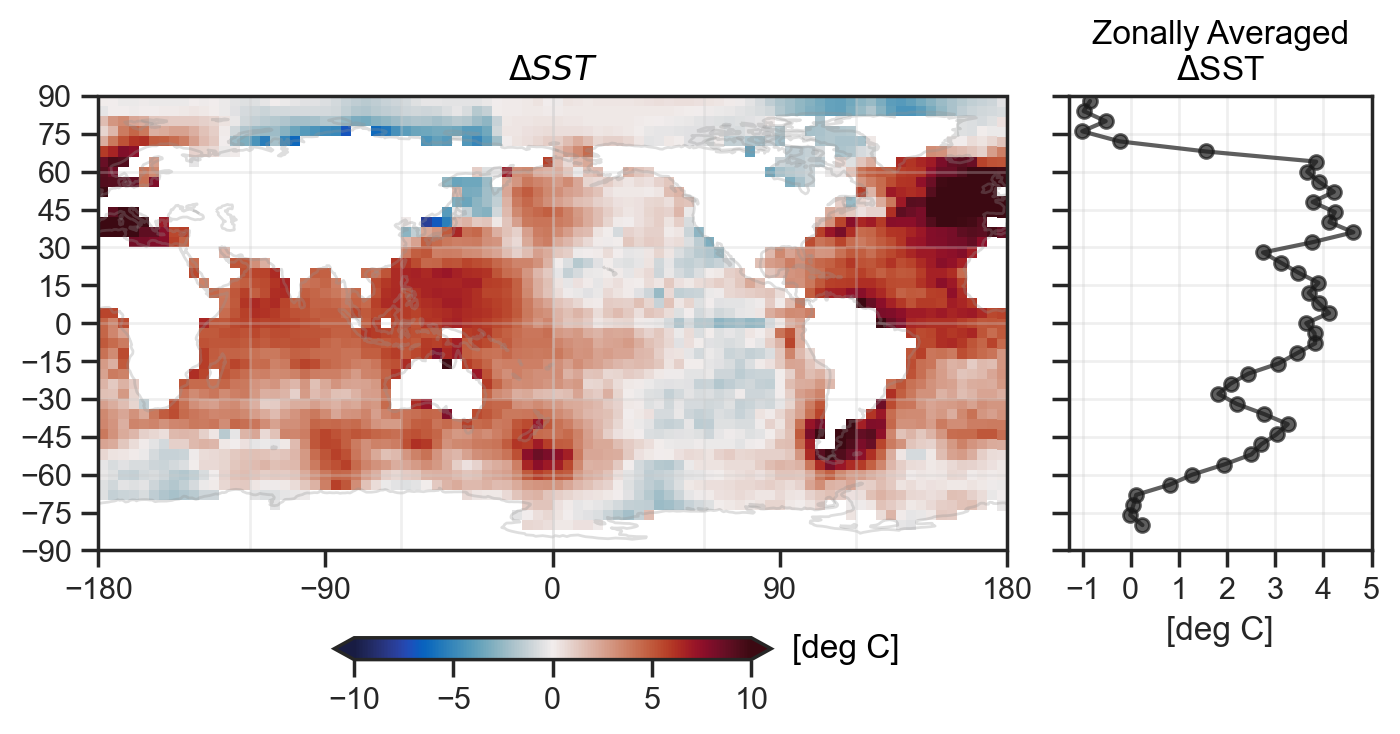

In [32]:
sns.set_theme(context="notebook", style="ticks", palette = "colorblind", rc=custom_style)

cm = pyimport("cmocean.cm")

figl = figure(figsize=(15, 5))
axl = figl.add_subplot(131,  projection=ccrs.PlateCarree(central_longitude = 180))

ΔSST = θ̄_mod_SST.tracer .- θ̄_LGM_SST.tracer
Δv = (volume_mod.tracer .- volume_LGM.tracer) ./ sum(cellvolume(γ))

temperatures_changes = ΔSST .* volume_LGM.tracer ./ sum(cellvolume(γ))

# axl.set_title()
axl.coastlines(color = "#949494", alpha = 0.3)
cml = axl.pcolormesh(γ.lon, γ.lat, ΔSST', cmap = cm.balance,
transform = ccrs.PlateCarree(),vmin = -10, vmax = 10)
axl.gridlines(alpha = 0.3)

axl.set_yticks(-90:15:90)
axl.set_xticks([-180, -90, 0, 90, 180])
cb = figl.colorbar(cml, orientation = "horizontal", extend = "both", fraction = 0.025, pad = 0.1)
# cb.ax.tick_params(rotation=45)
axl.set_title(L"\Delta SST ")
bbox = cb.ax.get_position()  # Bounding box in figure coordinates
x_pos = bbox.x1 + 0.75  # Slightly to the right of the colorbar
y_pos = (bbox.y0 + bbox.y1) / 2  # Vertically centered
# Add a horizontal label to the colorbar using ax.text
cb.ax.text(
    x_pos, y_pos, "[deg C]", 
    transform=cb.ax.transAxes, rotation=0
)

figl.tight_layout()
axl1 = figl.add_subplot(132)

pos1 = axl.get_position()  # returns the bounding box position of the first plot
height = pos1.height  # Get the height of the first subplot

pos2 = axl1.get_position()
axl1.set_position([pos2.x0, pos1.y0, pos2.width /3, height])  # Align the height

axl1.plot(ΔSST_lat, γ.lat, marker='o', c = "k", alpha = 0.7, markersize = 5)
axl1.set_yticks(-90:15:90)
axl1.set_ylim(-90, 90)
axl1.tick_params(labelleft=false)    
axl1.set_xticks(-1:5)
axl1.grid(alpha = 0.3)
axl1.set_title("Zonally Averaged\n" * L"\Delta" * "SST")
axl1.set_xlabel("[deg C]")

# fig.tight_layout()
figl.savefig(plotsdir("ΔSST_latitude.png"), dpi = 200, bbox_inches = "tight")
figl

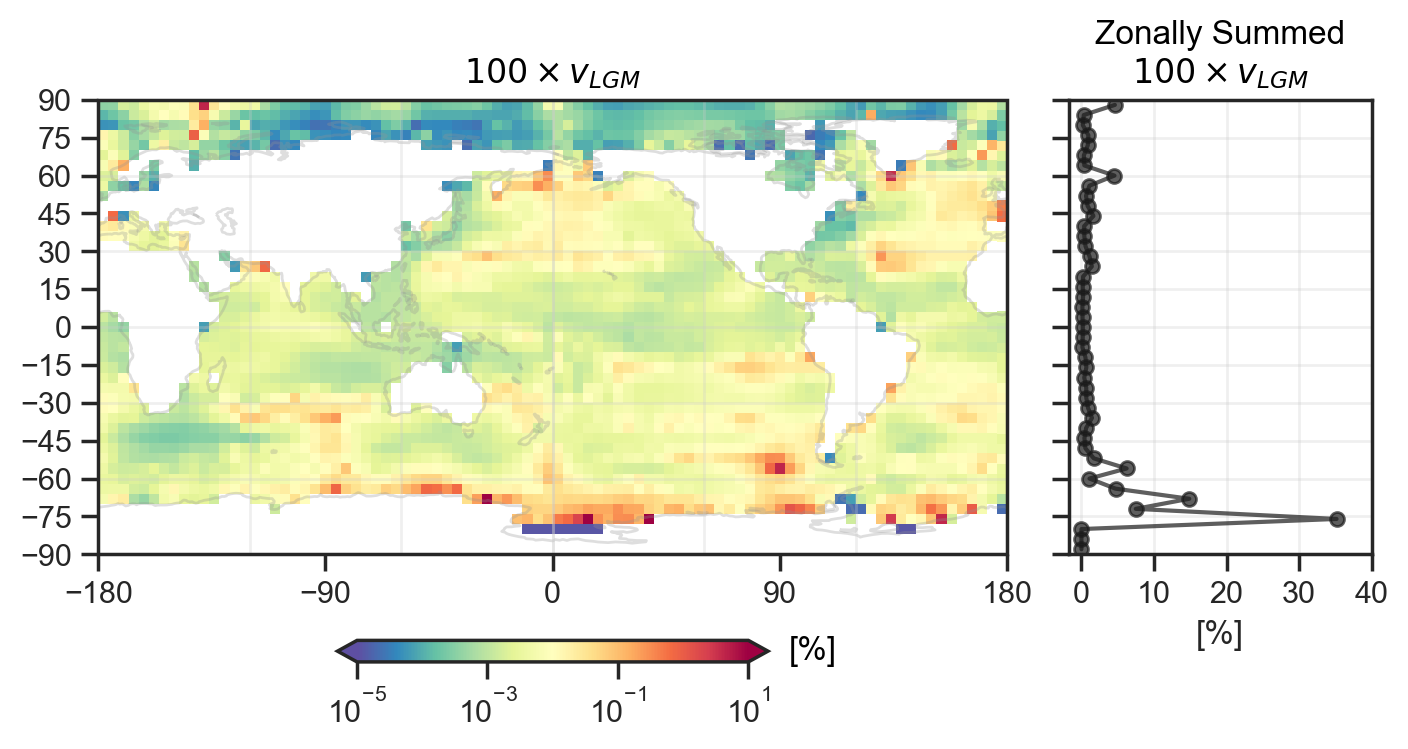

In [39]:
sns.set_theme(context="notebook", style="ticks", palette = "colorblind", rc=custom_style)

cm = pyimport("cmocean.cm")

figl = figure(figsize=(15, 5))
axl = figl.add_subplot(131,  projection=ccrs.PlateCarree(central_longitude = 180))

ΔSST = θ̄_mod_SST.tracer .- θ̄_LGM_SST.tracer
Δv = (volume_mod.tracer .- volume_LGM.tracer) ./ sum(cellvolume(γ))
vnorm = matplotlib.colors.LogNorm(vmin = 1e-5, vmax=1e1)
temperatures_changes = ΔSST .* volume_LGM.tracer ./ sum(cellvolume(γ))

# axl.set_title()
axl.coastlines(color = "#949494", alpha = 0.3)
cml = axl.pcolormesh(γ.lon, γ.lat, 100 .* volume_LGM.tracer' ./ sum(cellvolume(γ)), cmap = "Spectral_r",
transform = ccrs.PlateCarree(),norm = vnorm)
axl.gridlines(alpha = 0.3)

axl.set_yticks(-90:15:90)
axl.set_xticks([-180, -90, 0, 90, 180])
cb = figl.colorbar(cml, 
    extend = "both",
    fraction = 0.025, pad = 0.1,location="bottom")
# cb.ax.tick_params(rotation=45)
bbox = cb.ax.get_position()  # Bounding box in figure coordinates
x_pos = bbox.x1 + 0.75  # Slightly to the right of the colorbar
y_pos = (bbox.y0 + bbox.y1) / 2  # Vertically centered
# Add a horizontal label to the colorbar using ax.text
cb.ax.text(
    x_pos, y_pos, "[%]", 
    transform=cb.ax.transAxes, rotation=0
)
axl.set_title(L"100 \times v_{LGM}")
figl.tight_layout()
axl1 = figl.add_subplot(132)

pos1 = axl.get_position()  # returns the bounding box position of the first plot
height = pos1.height  # Get the height of the first subplot

pos2 = axl1.get_position()
axl1.set_position([pos2.x0, pos1.y0, pos2.width /3, height])  # Align the height

axl1.plot(100 .* lgm_lat_volumes, γ.lat, marker='o', c = "k", alpha = 0.7, markersize = 5)
axl1.set_yticks(-90:15:90)
axl1.set_ylim(-90, 90)
axl1.tick_params(labelleft=false)    
axl1.set_xticks(0:10:45)
axl1.grid(alpha = 0.3)
axl1.set_title("Zonally Summed\n" * L"100 \times v_{LGM}")
axl1.set_xlabel("[%]")

# fig.tight_layout()
figl.savefig(plotsdir("v_lgm_latitude.png"), dpi = 200, bbox_inches = "tight")
figl

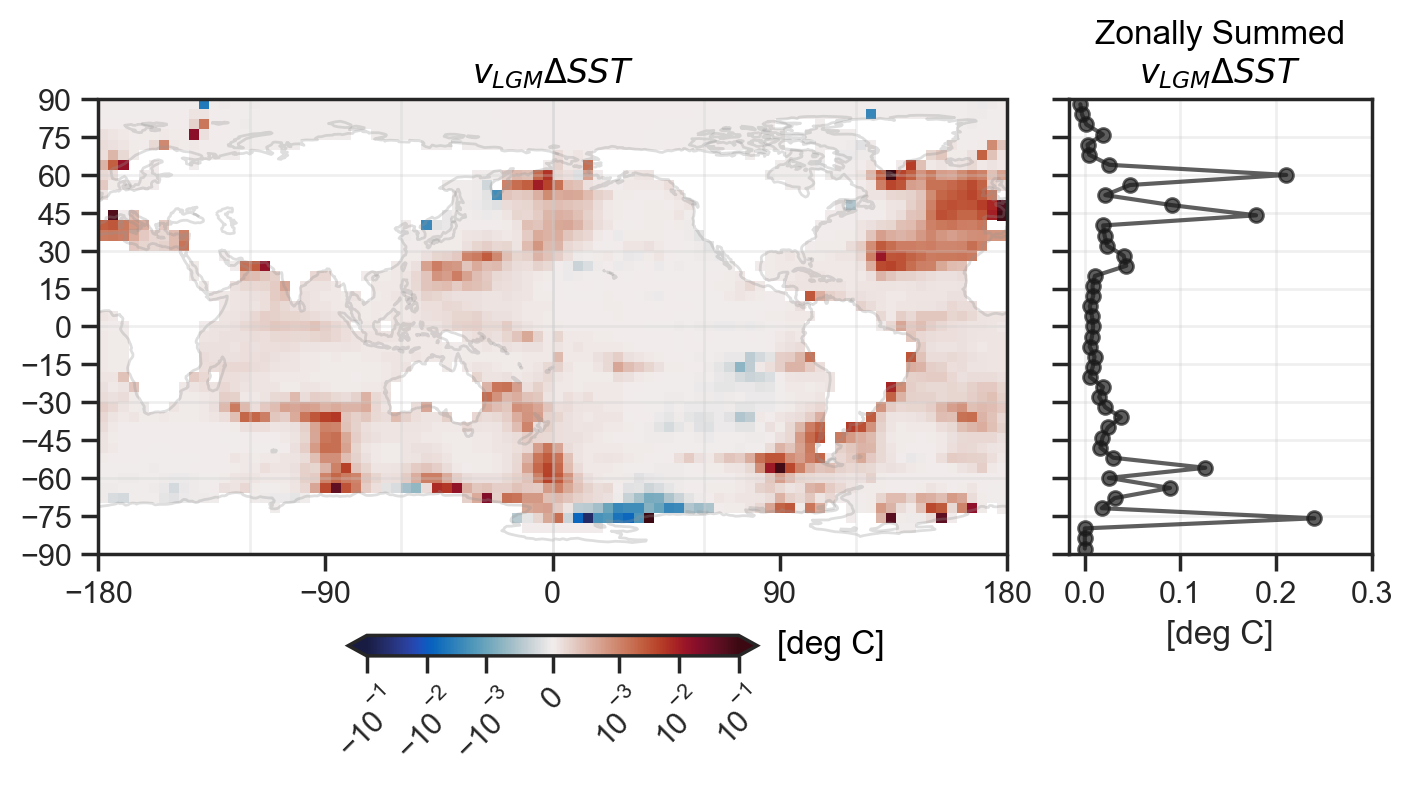

In [45]:
sns.set_theme(context="notebook", style="ticks", palette = "colorblind", rc=custom_style)

cm = pyimport("cmocean.cm")

figl = figure(figsize=(15, 5))
axl = figl.add_subplot(131,  projection=ccrs.PlateCarree(central_longitude = 180))

ΔSST = θ̄_mod_SST.tracer .- θ̄_LGM_SST.tracer
Δv = (volume_mod.tracer .- volume_LGM.tracer) ./ sum(cellvolume(γ))
vnorm = matplotlib.colors.SymLogNorm(linthresh =1e-3, vmin = -1e-1, vmax=1e-1)

temperatures_changes = ΔSST .* volume_LGM.tracer ./ sum(cellvolume(γ))
temperatures_changes_lat = nansum(temperatures_changes, dims = 1)
# axl.set_title()
axl.coastlines(color = "#949494", alpha = 0.3)
cml = axl.pcolormesh(γ.lon, γ.lat, temperatures_changes' , cmap = cm.balance,
transform = ccrs.PlateCarree(),norm = vnorm)
axl.gridlines(alpha = 0.3)

axl.set_yticks(-90:15:90)
axl.set_xticks([-180, -90, 0, 90, 180])
cb = figl.colorbar(cml, orientation = "horizontal", extend = "both", 
                   fraction = 0.025, pad = 0.1)

cb.ax.tick_params(rotation=45)

bbox = cb.ax.get_position()  # Bounding box in figure coordinates
x_pos = bbox.x1 + 0.75  # Slightly to the right of the colorbar
y_pos = (bbox.y0 + bbox.y1) / 2  # Vertically centered
# Add a horizontal label to the colorbar using ax.text
cb.ax.text(
    x_pos, y_pos, "[deg C]", 
    transform=cb.ax.transAxes, rotation=0
)
axl.set_title(L"v_{LGM} \Delta SST")

figl.tight_layout()
axl1 = figl.add_subplot(132)

pos1 = axl.get_position()  # returns the bounding box position of the first plot
height = pos1.height  # Get the height of the first subplot

pos2 = axl1.get_position()
axl1.set_position([pos2.x0, pos1.y0, pos2.width /3, height])  # Align the height

axl1.plot(temperatures_changes_lat[:], γ.lat, marker='o', c = "k", alpha = 0.7, markersize = 5)
axl1.set_yticks(-90:15:90)
axl1.set_ylim(-90, 90)
axl1.tick_params(labelleft=false)    
axl1.set_xticks(0:0.1:.3)
axl1.grid(alpha = 0.3)
axl1.set_title("Zonally Summed\n" * L"v_{LGM} \Delta SST")
axl1.set_xlabel("[deg C]")

# fig.tight_layout()
figl.savefig(plotsdir("ΔSST_v_lgm_latitude.png"), dpi = 200, bbox_inches = "tight")
figl

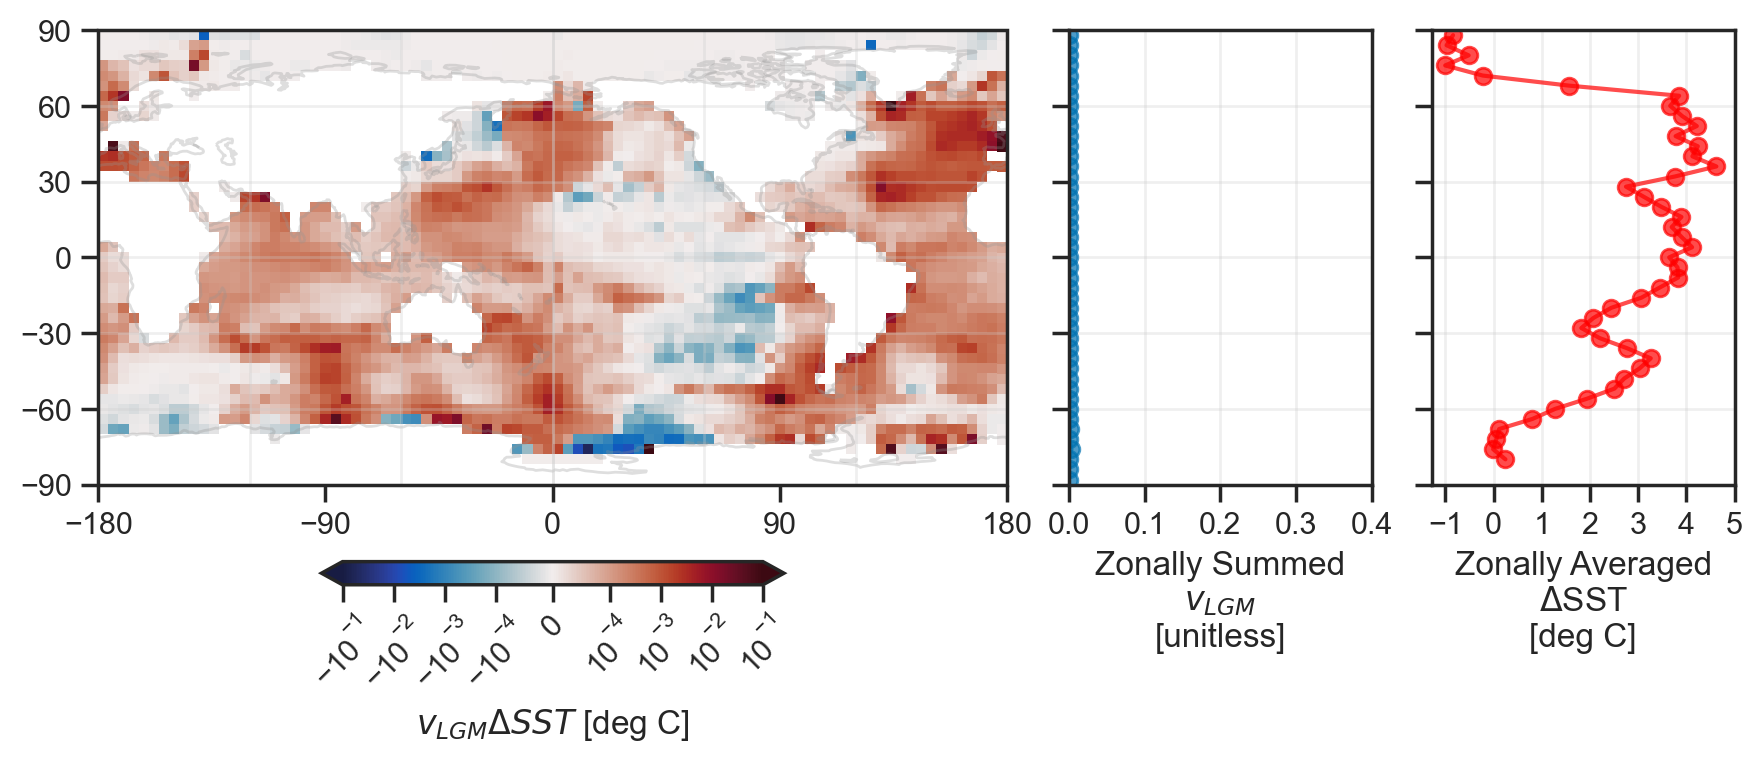

In [42]:
sns.set_theme(context="notebook", style="ticks", palette = "colorblind", rc=custom_style)

cm = pyimport("cmocean.cm")

figl = figure(figsize=(15, 5))
axl = figl.add_subplot(131,  projection=ccrs.PlateCarree(central_longitude = 180))


ΔSST = θ̄_mod_SST.tracer .- θ̄_LGM_SST.tracer
Δv = (volume_mod.tracer .- volume_LGM.tracer) ./ sum(cellvolume(γ))

temperatures_changes = ΔSST .* volume_LGM.tracer ./ sum(cellvolume(γ))
vnorm = matplotlib.colors.SymLogNorm(linthresh =1e-4, vmin = -1e-1, vmax=1e-1)

# axl.set_title()
axl.coastlines(color = "#949494", alpha = 0.3)
cml = axl.pcolormesh(γ.lon, γ.lat, temperatures_changes', cmap = cm.balance,
transform = ccrs.PlateCarree(),norm=vnorm)
axl.gridlines(alpha = 0.3)

axl.set_yticks(-90:30:90)
axl.set_xticks([-180, -90, 0, 90, 180])
cb = figl.colorbar(cml, orientation = "horizontal", extend = "both", label = L"v_{LGM} \Delta SST " * " [deg C]", fraction = 0.03, pad = 0.1)
cb.ax.tick_params(rotation=45)

figl.tight_layout()
axl1 = figl.add_subplot(132)
axl2 = figl.add_subplot(133)

pos1 = axl.get_position()  # returns the bounding box position of the first plot
height = pos1.height  # Get the height of the first subplot

pos2 = axl1.get_position()
axl1.set_position([pos2.x0, pos1.y0, pos2.width /3, height])  # Align the height

pos3 = axl2.get_position()
axl2.set_position([pos2.x0 + (pos2.width /3) + 0.02, pos1.y0, pos3.width /3 , height])  # Align the height

axl1.plot(lgm_lat_volumes ./ 100, γ.lat, marker='o', c = "b", alpha = 0.7)
axl1.set_yticks(-90:30:90)
axl1.set_ylim(-90, 90)
axl1.set_xticks(0:0.1:.45)
axl1.tick_params(labelleft=false)    
axl1.grid(alpha = 0.3)
axl1.set_xlabel("Zonally Summed\n" * L"v_{LGM}" * "\n[unitless]")

axl2.plot(ΔSST_lat, γ.lat, marker='o', c = "red", alpha = 0.7)
axl2.set_yticks(-90:30:90)
axl2.set_ylim(-90, 90)
axl2.tick_params(labelleft=false)    
axl2.set_xticks(-1:5)
axl2.grid(alpha = 0.3)
axl2.set_xlabel("Zonally Averaged\n" * L"\Delta" * "SST\n[deg C]")
figl
# fig.tight_layout()
# figl.savefig(plotsdir("MOT_decomp_vLGM_ΔSST.png"), dpi = 200, bbox_inches = "tight")